In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToPILImage
show = ToPILImage() # 可以把Tensor转成Image，方便可视化

In [24]:
# --------------------准备数据集------------------
# Dataset, DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), std =(0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True, 
                                        transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       transform=transform, 
                                       download=True)

trainloader = DataLoader(dataset=trainset, batch_size=4, shuffle=True)  # num_workers=4
testloader = DataLoader(dataset=testset, batch_size=4, shuffle=True)    # num_workers=4


Files already downloaded and verified
Files already downloaded and verified


In [25]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

torch.Size([3, 32, 32])
deer


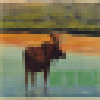

In [26]:
(data, label) = trainset[66]  
print(data.size())   # 验证某一张图片的维度 —— 3*32*32
print(classes[label]) # label是一个0-9的数字
# (data + 1) / 2是为了还原被归一化的数据 （这部分计算是可以推算出来的）
show((data + 1) / 2).resize((100, 100))

       ship         car        ship         cat


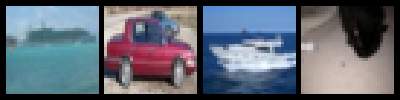

In [28]:
dataiter = iter(trainloader)   # trainloader is a DataLoader Object 
images, labels = dataiter.next() # 返回4张图片及标签   images,labels都是Tensor    images.size()= torch.Size([4, 3, 32, 32])     lables = tensor([5, 6, 3, 8])
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(torchvision.utils.make_grid((images+1)/2)).resize((400,100))

In [29]:
# 定义网络
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)  # 最后是一个十分类，所以最后的一个全连接层的神经元个数为10

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1)  # 展平  x.size()[0]是batch size
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [35]:
from torch import optim
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [31]:
# t.set_num_threads(4)
for epoch in range(2):  
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):   # i 第几个batch     data：一个batch中的数据
        
        # 输入数据
        inputs, labels = data   # images：batch大小为4     labels：batch大小为4
        
        # 梯度清零
        optimizer.zero_grad()
        
        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()   
        
        # 更新参数 
        optimizer.step()
        
        # 打印log信息
        # loss 是一个scalar,需要使用loss.item()来获取数值，不能使用loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print('[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')


[1,  2000] loss: 2.206
[1,  4000] loss: 1.902
[1,  6000] loss: 1.694
[1,  8000] loss: 1.607
[1, 10000] loss: 1.546
[1, 12000] loss: 1.495
[2,  2000] loss: 1.426
[2,  4000] loss: 1.386
[2,  6000] loss: 1.373
[2,  8000] loss: 1.354
[2, 10000] loss: 1.316
[2, 12000] loss: 1.312
Finished Training


In [36]:
# t.set_num_threads(4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
for epoch in range(2):  
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):   # i 第几个batch     data：一个batch中的数据
        
        # 输入数据
        inputs, labels = data   # images：batch大小为4     labels：batch大小为4
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 梯度清零
        optimizer.zero_grad()
        
        # forward + backward 
        net.cuda()
        outputs = net(inputs)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()   
        
        # 更新参数 
        optimizer.step()
        
        # 打印log信息
        # loss 是一个scalar,需要使用loss.item()来获取数值，不能使用loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print('[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

cuda:0
[1,  2000] loss: 1.248
[1,  4000] loss: 1.244
[1,  6000] loss: 1.225
[1,  8000] loss: 1.216
[1, 10000] loss: 1.192
[1, 12000] loss: 1.181
[2,  2000] loss: 1.132
[2,  4000] loss: 1.141
[2,  6000] loss: 1.115
[2,  8000] loss: 1.107
[2, 10000] loss: 1.118
[2, 12000] loss: 1.117
Finished Training


In [33]:
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数

# 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
with torch.no_grad():
    for data in testloader:      # data是个tuple
        images, labels = data    # image和label 都是tensor        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)    # labels tensor([3, 8, 8, 0])            labels.size: torch.Size([4])
        correct += (predicted == labels).sum()

print('10000张测试集中的准确率为: %d %%' % (100 * correct // total))


10000张测试集中的准确率为: 54 %
